# 殺害の手段を持つ人

In [1]:
# load modules 
from rdflib import (
  Graph, 
  URIRef, Literal, BNode,
  RDF, RDFS
)

import io  
import sys
import json
from collections import defaultdict
import re

sys.path.append('../src/')
from utils import *

In [2]:
knowledge_graph_dir = '../KnowledgeGraph/'
additional_knowledge_graph_dir = '../AdditionalKnowledgeGraph/'

## 殺人方法のオントロジー

### 殺害方法と症状

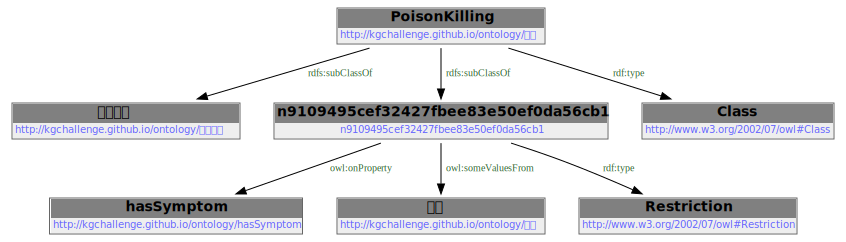

In [3]:
ttl = '''
kgcf:毒殺 rdf:type owl:Class ;
  rdfs:label "PoisonKilling"@en ,
             "毒殺"@ja ;
  rdfs:subClassOf kgcf:殺害方法 ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:嘔吐
    # ] ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:めまい
    # ] ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:青白い
    # ] ,
    [ rdf:type owl:Restriction ;
      owl:onProperty kgcf:hasSymptom ;
      owl:someValuesFrom kgcf:震え
    ] .
'''

print_ttl(ttl)

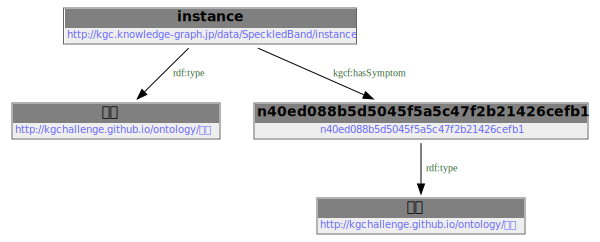

In [4]:
ttl = '''
kd:instance a kgcf:毒殺 ;
       kgcf:hasSymptom [
         a kgcf:震え
       ] .
'''

print_ttl(ttl)

### 犯罪供用物（凶器）と関連物

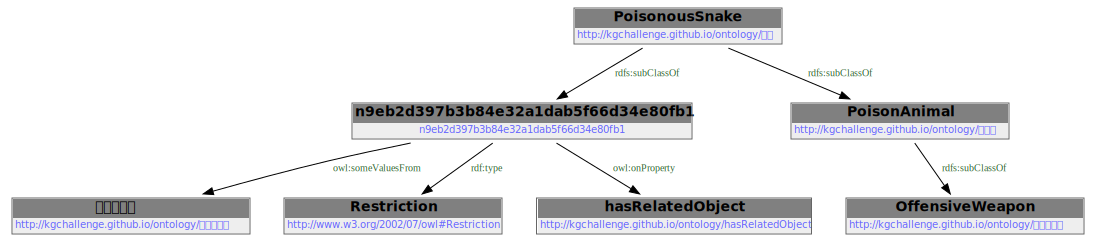

In [5]:
ttl = '''
###  http://kgchallenge.github.io/ontology/犯罪供用物
kgcf:犯罪供用物 # rdf:type owl:Class ;
  rdfs:label "OffensiveWeapon"@en ,
             "犯罪供用物"@ja .

###  http://kgchallenge.github.io/ontology/毒動物
kgcf:毒動物 # rdf:type owl:Class ;
  rdfs:subClassOf kgcf:犯罪供用物 ;
  rdfs:label "PoisonAnimal"@en ,
             "毒動物"@ja .

###  http://kgchallenge.github.io/ontology/毒蛇
kgcf:毒蛇 # rdf:type owl:Class ;
  rdfs:subClassOf kgcf:毒動物 ,
                  [ rdf:type owl:Restriction ;
                    owl:onProperty kgcf:hasRelatedObject ;
                    owl:someValuesFrom kgcf:蛇調教道具
                  ] ;
  rdfs:label "PoisonousSnake"@en ,
             "毒蛇"@ja .
'''

print_ttl(ttl)

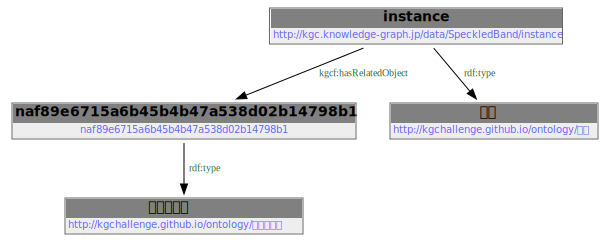

In [6]:
ttl = '''
kd:instance a kgcf:毒蛇 ;
       kgcf:hasRelatedObject [
         a kgcf:蛇調教道具
       ] .
'''

print_ttl(ttl)

### 上記をまとめたもの

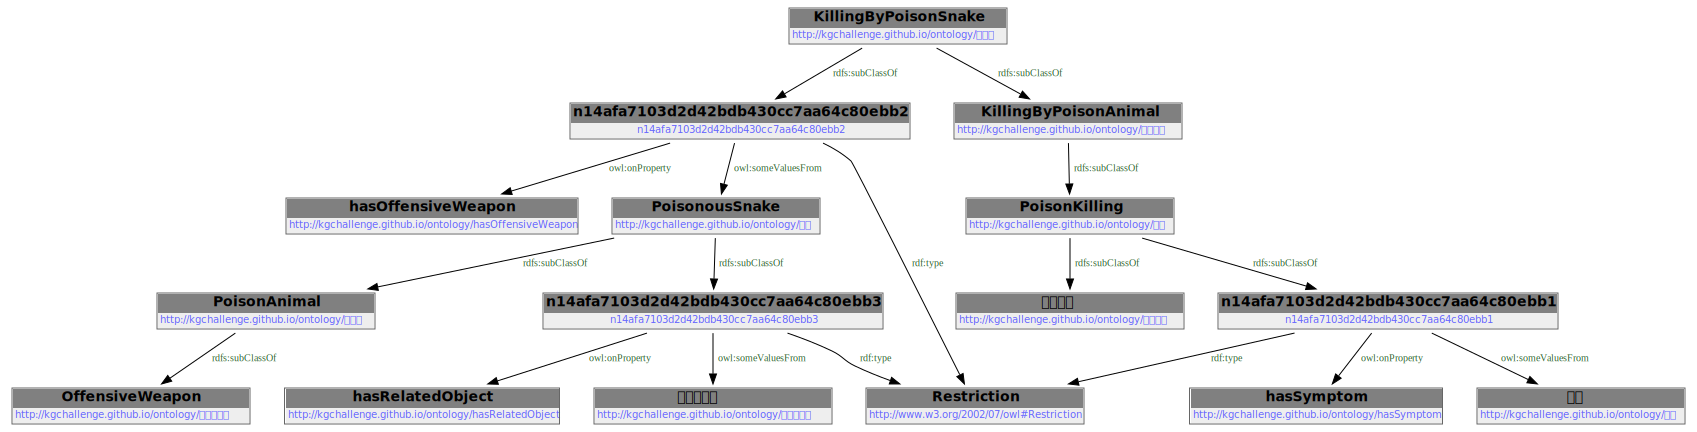

In [7]:
ttl = '''
##########################################################
# 殺害方法
##########################################################

kgcf:毒殺 rdfs:label "PoisonKilling"@en ,
             "毒殺"@ja ;
  rdfs:subClassOf kgcf:殺害方法 ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:嘔吐
    # ] ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:めまい
    # ] ,
    # [ rdf:type owl:Restriction ;
    #   owl:onProperty kgcf:hasSymptom ;
    #   owl:someValuesFrom kgcf:青白い
    # ] ,
    [ rdf:type owl:Restriction ;
      owl:onProperty kgcf:hasSymptom ;
      owl:someValuesFrom kgcf:震え
    ] .
###  http://kgchallenge.github.io/ontology/毒動物殺
kgcf:毒動物殺
  rdfs:subClassOf kgcf:毒殺 ;
  rdfs:label "KillingByPoisonAnimal"@en ,
             "毒動物殺"@ja .


###  http://kgchallenge.github.io/ontology/毒蛇殺
kgcf:毒蛇殺 
      rdfs:subClassOf kgcf:毒動物殺 ,
                      [ rdf:type owl:Restriction ;
                        owl:onProperty kgcf:hasOffensiveWeapon ;
                        owl:someValuesFrom kgcf:毒蛇
                      ] ;
      rdfs:label "KillingByPoisonSnake"@en ,
                 "毒蛇殺"@ja .             
             
##########################################################
# 犯罪供用物
##########################################################

###  http://kgchallenge.github.io/ontology/犯罪供用物
kgcf:犯罪供用物 
  rdfs:label "OffensiveWeapon"@en ,
             "犯罪供用物"@ja .

###  http://kgchallenge.github.io/ontology/毒動物
kgcf:毒動物 
  rdfs:subClassOf kgcf:犯罪供用物 ;
  rdfs:label "PoisonAnimal"@en ,
             "毒動物"@ja .


###  http://kgchallenge.github.io/ontology/毒蛇
kgcf:毒蛇 
  rdfs:subClassOf kgcf:毒動物 ,
                  [ rdf:type owl:Restriction ;
                    owl:onProperty kgcf:hasRelatedObject ;
                    owl:someValuesFrom kgcf:蛇調教道具
                  ] ;
  rdfs:label "PoisonousSnake"@en ,
             "毒蛇"@ja .

'''

print_ttl(ttl)

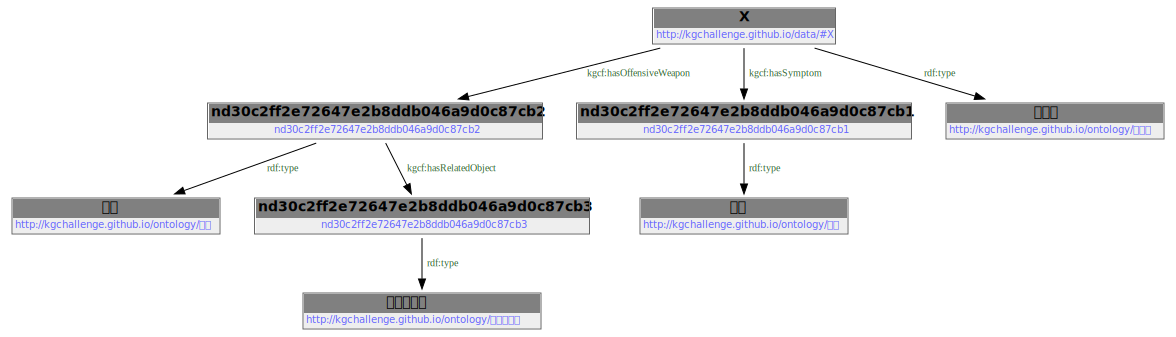

In [8]:
ttl = '''
kdf:X a kgcf:毒蛇殺;
  kgcf:hasSymptom [
    a kgcf:震え
  ];
  kgcf:hasOffensiveWeapon [
    a kgcf:毒蛇;
    kgcf:hasRelatedObject [
      a kgcf:蛇調教道具
    ]
  ]
  .
'''

print_ttl(ttl)

## 被害者の状態から，殺害方法を推論

In [9]:
g=Graph()
rdf_files = [
  f'{knowledge_graph_dir}/SpeckledBand_mod.ttl', 
  f'{additional_knowledge_graph_dir}/hokan.ttl', 
  f'{additional_knowledge_graph_dir}/root-ontology_modify2.ttl',
]
g = load_rdf_files(g, rdf_files)

### 事件当時の Julia の状態を確認

In [10]:
queries = dict()
q = '''
SELECT DISTINCT ?situation ?symptom_instance ?source WHERE {
  BIND("true" AS ?symptom_status)

  # 被害者がもつ症状を検索 （?symptom_instance がその症状）
  ?situation rdf:type kgc:Situation ;
             kgc:subject kd:Julia ;
             kgc:when kd:death_day_of_Julia ;
             kgc:hasProperty ?symptom_instance;
             kgc:source ?source .
  FILTER(LANG(?source)="ja")
}       
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

,situation,symptom_instance,source
0,kd:72,kd:turnPale,"""事件当夜，ジュリアは真っ青だった""@ja"
1,kd:73,kd:beDizzy,"""事件当夜，ジュリアはふらふらしていた""@ja"


### ルールを作成

In [11]:
queries = dict()
q = '''
SELECT distinct ?situation ?symptom_instance ?symptom ?symptom_status ?killing WHERE {
  BIND("true" AS ?symptom_status)

  # 被害者がもつ症状を検索 （?symptom_instance がその症状）
  ?situation rdf:type kgc:Situation ;
             kgc:subject kd:Julia ;
             kgc:when kd:death_day_of_Julia ;
             kgc:hasProperty ?symptom_instance .

  # 症状のクラスを検索
  ?symptom_instance a ?symptom .
  
  # その症状を持ちうる owl class を検索
  ?owl_class owl:onProperty kgcf:hasSymptom;
             owl:someValuesFrom ?symptom .
             
  # その owl class のサブクラスに当たるクラス（殺害方法のクラス）を検索
  ?killing rdfs:subClassOf+ ?owl_class .
}       
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

queries['symptom_without_scar'] = extract_rule(q)

,situation,symptom_instance,symptom,symptom_status,killing
0,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒殺
1,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒ガス殺
2,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒動物殺
3,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒蛇殺
4,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒蜘蛛殺
5,kd:72,kd:turnPale,kgcf:青白い,"""true""",kgcf:毒河豚殺
6,kd:73,kd:beDizzy,kgcf:めまい,"""true""",kgcf:毒殺
7,kd:73,kd:beDizzy,kgcf:めまい,"""true""",kgcf:毒ガス殺
8,kd:73,kd:beDizzy,kgcf:めまい,"""true""",kgcf:毒動物殺
9,kd:73,kd:beDizzy,kgcf:めまい,"""true""",kgcf:毒蛇殺


In [12]:
q = '''
SELECT distinct ?situation ?symptom_instance ?symptom ?symptom_status ?killing WHERE {
  BIND(kgcf:傷跡 AS ?symptom)
  BIND("false" AS ?symptom_status)

  ?situation rdf:type kgc:Situation ;
             kgc:subject kd:Julia ;
             kgc:when kd:death_day_of_Julia ;
             kgc:what ?symptom_instance ;
             kgc:hasPredicate ?pred .

  ?symptom_instance a ?symptom .
  ?killing rdfs:subClassOf+ kgcf:殺害方法 .

  # シーンの predicate が kd:notHave の場合のみを選択
  FILTER(?pred = kd:notHave)
                             
  # 傷跡が現れない殺人方法のみを選択
  FILTER NOT EXISTS {
    ?owl_class owl:onProperty kgcf:hasSymptom;
               owl:someValuesFrom ?symptom.
    ?killing rdfs:subClassOf+ ?owl_class .
  }    
}       
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

queries['no_scar'] = extract_rule(q)

,situation,symptom_instance,symptom,symptom_status,killing
0,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:薬殺
1,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒殺
2,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒ガス殺
3,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒動物殺
4,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒蛇殺
5,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒蜘蛛殺
6,kd:104,kd:scar,kgcf:傷跡,"""false""",kgcf:毒河豚殺


In [13]:
# 被害者の遺体の状況から，殺害方法を検索
first_result = g.query(q)

# 上記検索結果から，殺害方法のクラスのリストを取得
killings = set(get_value_from_sparql_result(first_result, 'killing')) # 重複は削除
killings = list(map(URIRef, killings))

print('===== killing list ======')
print('\n'.join(killings))

===== killing list ======
http://kgchallenge.github.io/ontology/毒動物殺
http://kgchallenge.github.io/ontology/毒蜘蛛殺
http://kgchallenge.github.io/ontology/毒ガス殺
http://kgchallenge.github.io/ontology/薬殺
http://kgchallenge.github.io/ontology/毒殺
http://kgchallenge.github.io/ontology/毒河豚殺
http://kgchallenge.github.io/ontology/毒蛇殺


## 殺害方法を実行できた人物を探す

### 上記で推論された殺害方法クラスに対して犯罪供用物クラスと関連物クラスを取得

In [ ]:
# ルールをまとめる
q = f'''
SELECT distinct ?situation ?symptom_instance ?symptom ?symptom_status ?killing WHERE {{
  {{
    {queries['symptom_without_scar']}
  }} UNION {{
    {queries['no_scar']}
  }}
}}
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

In [14]:
def getOffensiveWeaponClass(g, killing):
  '''
  殺害方法クラスから犯罪供用物クラスを取得
  '''
  
  q = f'''
    SELECT DISTINCT ?class {{
      {killing} rdfs:subClassOf ?hasOWRestriction .
      ?hasOWRestriction a owl:Restriction;
                        owl:onProperty kgcf:hasOffensiveWeapon ;
                        owl:someValuesFrom ?class .
    }}
  '''
  return(g.query(q))

def getRelatedObjectClass(g, owclass):
  '''
  犯罪供用物クラスの関連物を取得
  '''
  
  q = f'''
  SELECT DISTINCT ?class {{
    {owclass} (^rdfs:subClassOf*)/rdfs:subClassOf ?hasOWRestriction .
    ?hasOWRestriction a owl:Restriction;
                      owl:onProperty kgcf:hasRelatedObject ;
                      owl:someValuesFrom ?class .
  }}
  '''
  return(g.query(q))


owlClassDict = defaultdict(lambda :defaultdict(list))
for killing in killings:
  
  # 殺害方法のクラス (killing) から犯罪供用物のクラス (weapon) を検索
  for owclass in getOffensiveWeaponClass(g, killing.n3()):
    weapon = owclass[0].n3()
    owlClassDict[killing]['weapon'].append(weapon)
    
    # 犯罪供用物のクラス (weapon) から 関連物 (related) を検索
    for related in getRelatedObjectClass(g, weapon):
      related_object = related[0].n3()
      owlClassDict[killing]['related'].append(related_object)
      
print('====== owl class dict ======')
print(json.dumps(owlClassDict, indent=2, ensure_ascii=False))
print()
  

====== owl class dict ======
{
  "http://kgchallenge.github.io/ontology/毒動物殺": {
    "weapon": [
      "<http://kgchallenge.github.io/ontology/毒動物>"
    ],
    "related": [
      "<http://kgchallenge.github.io/ontology/蛇調教道具>",
      "<http://kgchallenge.github.io/ontology/水槽>"
    ]
  },
  "http://kgchallenge.github.io/ontology/毒蜘蛛殺": {
    "weapon": [
      "<http://kgchallenge.github.io/ontology/毒蜘蛛>"
    ]
  },
  "http://kgchallenge.github.io/ontology/毒ガス殺": {
    "weapon": [
      "<http://kgchallenge.github.io/ontology/毒ガス>"
    ],
    "related": [
      "<http://kgchallenge.github.io/ontology/毒ガス保存容器>"
    ]
  },
  "http://kgchallenge.github.io/ontology/薬殺": {
    "weapon": [
      "<http://kgchallenge.github.io/ontology/薬物>"
    ]
  },
  "http://kgchallenge.github.io/ontology/毒河豚殺": {
    "weapon": [
      "<http://kgchallenge.github.io/ontology/河豚>"
    ],
    "related": [
      "<http://kgchallenge.github.io/ontology/水槽>"
    ]
  },
  "http://kgchallenge.github.io/ontology/毒蛇

### 各殺害方法クラスに対して，犯罪供用物または関連物を持つ人物を検索

In [16]:
def selectPerson_Reason(g, obj):
  '''
  g 上で obj から （それを持つ人，objのインスタンス，シーン） を検索
  '''
  
  q = f"""
  SELECT distinct ?person ?reason ?situation {{
    ?person a kgc:Person .
    ?reason a/(rdfs:subClassOf*) {obj} . # obj は 犯罪供用物 or 関連物
    
    {{
      ?situation kgc:hasPredicate kd:exist ;
                 kgc:where/kgc:ofWhole ?person ;
                 kgc:subject ?reason .
    }}
    
    UNION {{
      ?situation kgc:hasPredicate kd:have ;
                 kgc:subject ?person ;
                 kgc:what ?reason .
    }}
  }}
  """
  return g.query(q)

def getResultList(g, obj):
  '''
  obj（犯罪供用物もしくはその関連物）を持つ人のリストを導出
  '''
  res_list = []
  for res in selectPerson_Reason(g, obj):
    res = list(map(lambda x: x.n3(), res))
    res_list.append(res)
  return res_list


resultDict = defaultdict(lambda : defaultdict(list))
for killing in owlClassDict.keys():
  for weapon in owlClassDict[killing]['weapon']:
    # 犯罪共用物 (weapon) クラスのインスタンスを持つ （人，そのインスタンス，シーン） を得る
    results = getResultList(g, weapon)
    resultDict[killing]['weapon'].extend(results)
  for related in owlClassDict[killing]['related']:
    # 関連物 (related) クラスのインスタンスを持つ （人，そのインスタンス，シーン） を得る
    results = getResultList(g, related)
    resultDict[killing]['related'].extend(results)
    
print('====== resultDict ======')
print(json.dumps(resultDict, indent=2, ensure_ascii=False))

====== resultDict ======
{
  "http://kgchallenge.github.io/ontology/毒動物殺": {
    "weapon": [],
    "related": [
      [
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/Roylott>",
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/whip>",
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/390>"
      ]
    ]
  },
  "http://kgchallenge.github.io/ontology/毒蜘蛛殺": {
    "weapon": []
  },
  "http://kgchallenge.github.io/ontology/毒ガス殺": {
    "weapon": [],
    "related": []
  },
  "http://kgchallenge.github.io/ontology/薬殺": {
    "weapon": []
  },
  "http://kgchallenge.github.io/ontology/毒河豚殺": {
    "weapon": [],
    "related": []
  },
  "http://kgchallenge.github.io/ontology/毒蛇殺": {
    "weapon": [],
    "related": [
      [
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/Roylott>",
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/whip>",
        "<http://kgc.knowledge-graph.jp/data/SpeckledBand/390>"
      ]
    ]
  }
}


### 整形

In [17]:
result_json = list()
for killing, reason_to_results in resultDict.items():
  for reason, _results in reason_to_results.items():
    for result in _results:
      result_json.append(
        {
          'person': result[0],
          'killing': killing, 
          f'{reason}_reason': result[1],
          'reason_situ': result[2],
        })
      
def getResultGraph(result):
  result_graph=Graph()
  person_reason=BNode()
  method_uri=BNode()
  statement_node=BNode()
  
  has_method=URIRef("http://kgchallenge.github.io/ontology/has_method")
  has_reason=URIRef("http://kgchallenge.github.io/ontology/has_reason")
  related_reason=URIRef("http://kgchallenge.github.io/ontology/related_reason")
  object_reason=URIRef("http://kgchallenge.github.io/ontology/object_reason")
  reason_situ=URIRef("http://kgchallenge.github.io/ontology/reason_situ")
  
  result_graph.add((method_uri,RDF.type,URIRef(result["killing"][1:-1])))
  result_graph.add((URIRef(result["person"][1:-1]),has_method,method_uri))
  result_graph.add((statement_node,RDF.subject,URIRef(result["person"][1:-1])))
  result_graph.add((statement_node,RDF.predicate,has_method))
  result_graph.add((statement_node,RDF.object,method_uri))
  result_graph.add((statement_node,RDF.type,RDF.Statement))
  
  reason_node=BNode()
  result_graph.add((statement_node,has_reason,reason_node))
  result_graph.add((reason_node,related_reason,URIRef(result["related_reason"][1:-1])))
  result_graph.add((reason_node,reason_situ,URIRef(result["reason_situ"][1:-1])))
  
  return(result_graph)


### RDFグラフに変換
result_graph=Graph()
for result in result_json:
  result_graph=result_graph+getResultGraph(result)

@prefix ns1: <http://kgchallenge.github.io/ontology/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<http://kgc.knowledge-graph.jp/data/SpeckledBand/Roylott> ns1:has_method _:N8196191c69c64bfdaff04083e0890de8,
        _:Na56a59e272044bc8bf9c4ee14920015c .

[] a rdf:Statement ;
    ns1:has_reason [ ns1:reason_situ <http://kgc.knowledge-graph.jp/data/SpeckledBand/390> ;
            ns1:related_reason <http://kgc.knowledge-graph.jp/data/SpeckledBand/whip> ] ;
    rdf:object _:Na56a59e272044bc8bf9c4ee14920015c ;
    rdf:predicate ns1:has_method ;
    rdf:subject <http://kgc.knowledge-graph.jp/data/SpeckledBand/Roylott> .

[] a rdf:Statement ;
    ns1:has_reason [ ns1:reason_situ <http://kgc.knowledge-graph.jp/data/SpeckledBand/390> ;
            ns1:related_reason <http://kgc.knowledge-graph.jp/data/SpeckledBand/whip> ] ;
    rdf:object _:N8196191c69c64bfdaff04083e0890de8 ;
    rdf:predicate ns1:has_method ;
    rdf:subject <http://kgc.knowledge-graph.jp/data/SpeckledBand

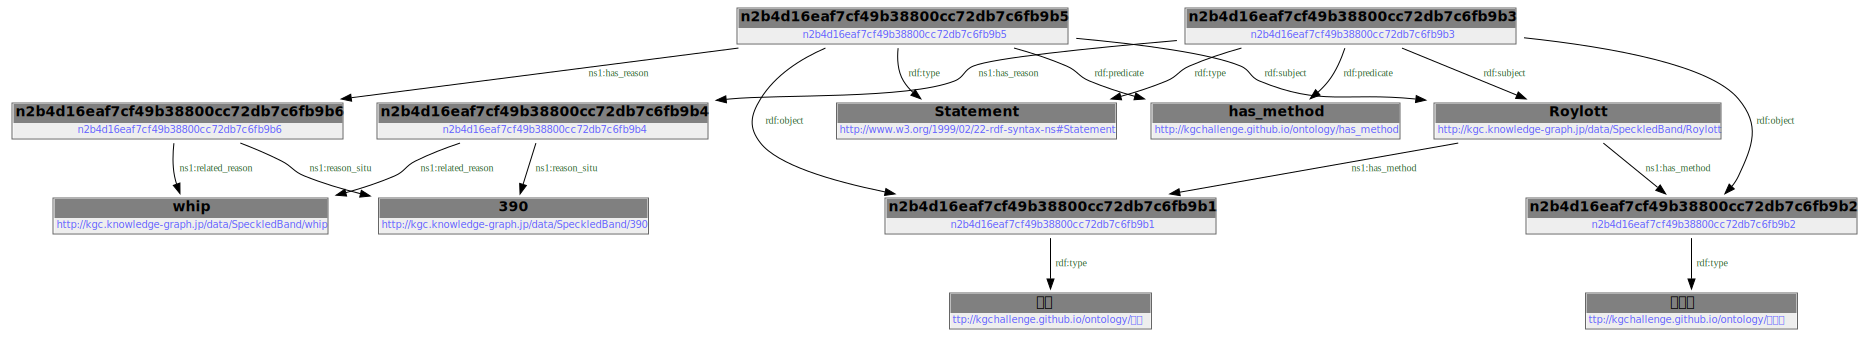

In [18]:
print(result_graph.serialize(format="turtle"))
print_ttl(result_graph.serialize())